 # Train file 
 ---
 For the model we will start by showing that we can purely train on depths 1 and 2 as those are the first instances containing every possible block

## Shift in the overall goal of this project:
---
Originally this project started with the goal to combine two networks together to create stereoscopic images based on surrealist art. However, this process, while definitely possible through sets of linear translations and object degmentation, is impractical for real runtime arguments. So here in the notebooks we provide a proof of concept for the network, however we will be turning this into a script for the Blender and Maxwell tools for 3-D modelling

Blender: Construct a 3D set of objects in a constrained 3-D domain
Maxwell: Render these objects

For now we will focus on a proof of concept ProGAN, and from there we repurpose this gan for our script.

In [1]:
### - imports - ###
from PIL import Image
import numpy as np
import glob
import cv2 as cv
import os
import random
import argparse
### - other data augmentation imports - ### (if needed)
### - Imports - ###
import math
import numpy as np
import sklearn as sk #general imports, initial data preprocessing/OS stuff
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import torch as T
import torch.nn as nn
import torch.optim as optim #Neural network imports, multiply data etc
from torchvision.transforms import ToTensor
import torchvision.models as models
import torchvision
import torch.nn.functional as F #Neural Network used in Comp4660 at ANU

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.metrics import confusion_matrix #analysis
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

from torchvision.datasets import ImageFolder
from NetworkMain import D, G
from tqdm import tqdm

Random Seed:  999


C:\Users\campb\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\campb\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#This code will be added later when the file is converted to a python file
"""parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./', help='directory contrains the data and outputs')
parser.add_argument('--epochs', type=int, default=40, help='training epoch number')
parser.add_argument('--out_res', type=int, default=128, help='The resolution of final output image')
parser.add_argument('--resume', type=int, default=0, help='continues from epoch number')
parser.add_argument('--cuda', action='store_true', help='Using GPU to train')


opt = parser.parse_args()"""

root = '/Users/campb/Documents/PersonalProjects/AGRNet/'
data_dir = root + 'Dataset/'
check_point_dir = root + 'check_points/'
output_dir = root + 'output/'
weight_dir = root+ 'weight/'
if not os.path.exists(check_point_dir):
	os.makedirs(check_point_dir)
if not os.path.exists(output_dir):
	os.makedirs(output_dir)
if not os.path.exists(weight_dir):
	os.makedirs(weight_dir)

In [3]:
### - Global Variables - ###
DFP = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/Sample-'

img_folder = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/'

NS = '/Sample-'

image_format = 'RGB'

schedule = [[5, 15, 25 ,35, 40],[6, 5, 5, 5, 4],[5, 5, 5, 1, 1]] #Epochs for each cycle num of epochs

batch_size = schedule[1][0]

growing = schedule[2][0]

epochs = 40

latent_size = 512

out_res = 1024

lr = 1e-5

lambd = 10

In [4]:
device = T.device('cuda:0' if (T.cuda.is_available())  else 'cpu')

transform = transforms.Compose([
            transforms.Resize(out_res),
            transforms.CenterCrop(out_res),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
print(device)

cuda:0


In [5]:
#Create networks
Disc = None
Gen = None
Disc = D(latent_size, out_res).to(device)
Gen = G(latent_size, out_res).to(device)

In [6]:
#Noise for discriminator
fixed_noise = T.randn(16, latent_size, 1, 1).to(device)
#initialize optimizers
D_optimizer = optim.Adam(Disc.parameters(), lr=lr, betas=(0, 0.99))
G_optimizer = optim.Adam(Gen.parameters(), lr=lr, betas=(0, 0.99))
#Metric variables
D_running_loss = 0.0
G_running_loss = 0.0
iter_num = 0

D_epoch_losses = []
G_epoch_losses = []

In [7]:
#Load with ImageFolder wrapper
class ImageDataset(Dataset):
    def __init__(self,img_folder,names, transform):
        self.transform = transform
        self.image_names = names #Predetermined dataset
        self.img_folder=img_folder
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self,index):
        image=Image.open(self.img_folder+self.image_names[index]).convert("RGB")
        image=self.transform(image)
        return image

assert(os.path.exists(DFP + str(1) + ".jpg"))
rawimgf = sorted(glob.glob(DFP + '*.jpg', recursive = True))
### - image names - ###
imnames = [i.split('/')[-1].split("t")[-1][1:] for i in rawimgf]

### - Global data loader Vars - ###
norms = (0.5,0.5,0.5), (0.5,0.5,0.5)
train_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((out_res, out_res))])
# Parameters
params = {'batch_size': schedule[1][0],
          'shuffle': True,
         'num_workers': 0}

In [8]:
#Control variable
resume = 0
if resume != 0:
    check_point = T.load(check_point_dir+'check_point_epoch_%i.pth' % resume)
    fixed_noise = check_point['fixed_noise']
    G_net.load_state_dict(check_point['G_net'])
    D_net.load_state_dict(check_point['D_net'])
    G_optimizer.load_state_dict(check_point['G_optimizer'])
    D_optimizer.load_state_dict(check_point['D_optimizer'])
    G_epoch_losses = check_point['G_epoch_losses']
    D_epoch_losses = check_point['D_epoch_losses']
    G_net.depth = check_point['depth']
    D_net.depth = check_point['depth']
    G_net.alpha = check_point['alpha']
    D_net.alpha = check_point['alpha']



c = next(x[0] for x in enumerate(schedule[0]) if x[1]>resume)-1
batch_size = schedule[1][c]
growing = schedule[2][c]
dataset = ImageDataset(img_folder, imnames, train_transform)
# dataset = datasets.CelebA(data_dir, split='all', transform=transform)
data_loader = DataLoader(dataset, **params)

tot_iter_num = (len(dataset)/batch_size)
Gen.fade_iters = (1-Gen.alpha)/(schedule[0][c+1]-resume)/(2*tot_iter_num)
Disc.fade_iters = (1-Disc.alpha)/(schedule[0][c+1]-resume)/(2*tot_iter_num)

"""
except:
    print('Fully Grown\n')
    c = -1
    batch_size = schedule[1][c]
    growing = schedule[2][c]

    dataset = ImageDataset(img_folder,imnames, train_transform)
    data_loader = DataLoader(dataset, **params)

    tot_iter_num = (len(dataset)/batch_size)
    print(schedule[0][c], resume)

    if Gen.alpha < 1:
        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)
        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"""


"\nexcept:\n    print('Fully Grown\n')\n    c = -1\n    batch_size = schedule[1][c]\n    growing = schedule[2][c]\n\n    dataset = ImageDataset(img_folder,imnames, train_transform)\n    data_loader = DataLoader(dataset, **params)\n\n    tot_iter_num = (len(dataset)/batch_size)\n    print(schedule[0][c], resume)\n\n    if Gen.alpha < 1:\n        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)\n        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"

Output Resolution: 4 x 4
epoch: 1/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 2.487   G_loss: 0.007:   4%|█▉                                                  | 1/27 [00:02<00:59,  2.31s/it]

iteration : 0, gp: 2.66


D_loss: 2.487   G_loss: 0.007:   7%|███▊                                                | 2/27 [00:02<00:30,  1.24s/it]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 2.487   G_loss: 0.007:  11%|█████▊                                              | 3/27 [00:03<00:18,  1.30it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 2.228   G_loss: 0.009:  15%|███████▋                                            | 4/27 [00:03<00:12,  1.86it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 3, gp: 2.47
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 2.228   G_loss: 0.009:  22%|███████████▌                                        | 6/27 [00:03<00:07,  3.00it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 2.027   G_loss: 0.005:  26%|█████████████▍                                      | 7/27 [00:03<00:05,  3.45it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 6, gp: 2.14
torch.Size([6, 512, 4, 4])


D_loss: 2.027   G_loss: 0.005:  30%|███████████████▍                                    | 8/27 [00:03<00:04,  3.89it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 2.027   G_loss: 0.005:  33%|█████████████████▎                                  | 9/27 [00:04<00:04,  4.24it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.836   G_loss: 0.016:  41%|████████████████████▊                              | 11/27 [00:04<00:03,  4.97it/s]

iteration : 9, gp: 2.22
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.836   G_loss: 0.016:  44%|██████████████████████▋                            | 12/27 [00:04<00:02,  5.04it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.742   G_loss: 0.016:  48%|████████████████████████▌                          | 13/27 [00:05<00:03,  3.95it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 12, gp: 1.99
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.742   G_loss: 0.016:  56%|████████████████████████████▎                      | 15/27 [00:05<00:02,  4.77it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.540   G_loss: 0.020:  63%|████████████████████████████████                   | 17/27 [00:05<00:01,  5.12it/s]

iteration : 15, gp: 1.72
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.540   G_loss: 0.020:  67%|██████████████████████████████████                 | 18/27 [00:06<00:02,  4.23it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.329   G_loss: 0.016:  74%|█████████████████████████████████████▊             | 20/27 [00:06<00:01,  5.00it/s]

iteration : 18, gp: 1.90
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.329   G_loss: 0.016:  78%|███████████████████████████████████████▋           | 21/27 [00:06<00:01,  5.17it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.370   G_loss: 0.017:  85%|███████████████████████████████████████████▍       | 23/27 [00:06<00:00,  5.33it/s]

iteration : 21, gp: 1.59
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.370   G_loss: 0.017:  89%|█████████████████████████████████████████████▎     | 24/27 [00:07<00:00,  5.49it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.195   G_loss: 0.017:  96%|█████████████████████████████████████████████████  | 26/27 [00:07<00:00,  5.55it/s]

iteration : 24, gp: 1.43
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.195   G_loss: 0.017: 100%|███████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.54it/s]


torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
epoch: 2/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.854   G_loss: 0.025:   0%|                                                            | 0/27 [00:00<?, ?it/s]

iteration : 0, gp: 1.45


D_loss: 0.854   G_loss: 0.025:   7%|███▊                                                | 2/27 [00:00<00:06,  4.09it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.854   G_loss: 0.025:  11%|█████▊                                              | 3/27 [00:00<00:05,  4.74it/s]

torch.Size([6, 512, 4, 4])


D_loss: 0.885   G_loss: 0.017:  15%|███████▋                                            | 4/27 [00:00<00:04,  5.04it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 3, gp: 1.38
torch.Size([6, 512, 4, 4])


D_loss: 0.885   G_loss: 0.017:  19%|█████████▋                                          | 5/27 [00:01<00:04,  5.10it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.885   G_loss: 0.017:  22%|███████████▌                                        | 6/27 [00:01<00:04,  5.16it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.822   G_loss: 0.021:  30%|███████████████▍                                    | 8/27 [00:01<00:03,  5.45it/s]

iteration : 6, gp: 1.55
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.822   G_loss: 0.021:  33%|█████████████████▎                                  | 9/27 [00:01<00:03,  5.41it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.597   G_loss: 0.014:  37%|██████████████████▉                                | 10/27 [00:02<00:03,  4.27it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 9, gp: 1.02
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.597   G_loss: 0.014:  44%|██████████████████████▋                            | 12/27 [00:02<00:04,  3.24it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.418   G_loss: 0.031:  48%|████████████████████████▌                          | 13/27 [00:03<00:04,  2.99it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 12, gp: 0.93
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.418   G_loss: 0.031:  52%|██████████████████████████▍                        | 14/27 [00:03<00:03,  3.49it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.379   G_loss: 0.034:  59%|██████████████████████████████▏                    | 16/27 [00:03<00:02,  4.38it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 15, gp: 0.89
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.379   G_loss: 0.034:  67%|██████████████████████████████████                 | 18/27 [00:04<00:01,  4.90it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.166   G_loss: 0.032:  74%|█████████████████████████████████████▊             | 20/27 [00:04<00:01,  5.21it/s]

iteration : 18, gp: 0.84
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.166   G_loss: 0.032:  78%|███████████████████████████████████████▋           | 21/27 [00:04<00:01,  5.14it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.188   G_loss: 0.041:  85%|███████████████████████████████████████████▍       | 23/27 [00:04<00:00,  5.47it/s]

iteration : 21, gp: 0.61
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.188   G_loss: 0.041:  89%|█████████████████████████████████████████████▎     | 24/27 [00:05<00:00,  5.41it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.205   G_loss: 0.051:  96%|█████████████████████████████████████████████████  | 26/27 [00:05<00:00,  5.64it/s]

iteration : 24, gp: 0.64
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.205   G_loss: 0.051: 100%|███████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.74it/s]


torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
epoch: 3/40


D_loss: 0.408   G_loss: 0.045:   4%|█▉                                                  | 1/27 [00:00<00:04,  5.88it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 0, gp: 0.52
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.408   G_loss: 0.045:   7%|███▊                                                | 2/27 [00:00<00:04,  5.92it/s]

torch.Size([6, 512, 4, 4])


D_loss: 0.408   G_loss: 0.045:  11%|█████▊                                              | 3/27 [00:00<00:04,  5.65it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.343   G_loss: 0.058:  15%|███████▋                                            | 4/27 [00:00<00:04,  5.55it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 3, gp: 0.52
torch.Size([6, 512, 4, 4])


D_loss: 0.343   G_loss: 0.058:  19%|█████████▋                                          | 5/27 [00:00<00:04,  5.46it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.456   G_loss: 0.056:  26%|█████████████▍                                      | 7/27 [00:01<00:03,  5.44it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 6, gp: 0.51
torch.Size([6, 512, 4, 4])


D_loss: 0.456   G_loss: 0.056:  30%|███████████████▍                                    | 8/27 [00:01<00:03,  5.47it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.456   G_loss: 0.056:  33%|█████████████████▎                                  | 9/27 [00:01<00:03,  5.42it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.328   G_loss: 0.066:  41%|████████████████████▊                              | 11/27 [00:01<00:02,  5.60it/s]

iteration : 9, gp: 0.63
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.328   G_loss: 0.066:  44%|██████████████████████▋                            | 12/27 [00:02<00:02,  5.66it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.481   G_loss: 0.059:  48%|████████████████████████▌                          | 13/27 [00:02<00:02,  5.58it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 12, gp: 0.37
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.481   G_loss: 0.059:  56%|████████████████████████████▎                      | 15/27 [00:02<00:02,  5.57it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.691   G_loss: 0.096:  63%|████████████████████████████████                   | 17/27 [00:03<00:01,  5.60it/s]

iteration : 15, gp: 0.27
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.691   G_loss: 0.096:  67%|██████████████████████████████████                 | 18/27 [00:03<00:01,  5.68it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.903   G_loss: 0.087:  70%|███████████████████████████████████▉               | 19/27 [00:03<00:01,  5.74it/s]

iteration : 18, gp: 0.39


D_loss: 0.903   G_loss: 0.087:  74%|█████████████████████████████████████▊             | 20/27 [00:03<00:01,  4.11it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.903   G_loss: 0.087:  78%|███████████████████████████████████████▋           | 21/27 [00:03<00:01,  4.48it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.839   G_loss: 0.086:  81%|█████████████████████████████████████████▌         | 22/27 [00:04<00:01,  4.78it/s]

iteration : 21, gp: 0.25


D_loss: 0.839   G_loss: 0.086:  85%|███████████████████████████████████████████▍       | 23/27 [00:04<00:01,  3.80it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.839   G_loss: 0.086:  89%|█████████████████████████████████████████████▎     | 24/27 [00:04<00:00,  4.14it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.956   G_loss: 0.095:  93%|███████████████████████████████████████████████▏   | 25/27 [00:04<00:00,  4.44it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 24, gp: 0.15
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.956   G_loss: 0.095: 100%|███████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.82it/s]

torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])


epoch: 4/40


D_loss: 1.110   G_loss: 0.108:   4%|█▉                                                  | 1/27 [00:00<00:04,  5.56it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 0, gp: 0.17
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.110   G_loss: 0.108:   7%|███▊                                                | 2/27 [00:00<00:04,  5.65it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.110   G_loss: 0.108:  11%|█████▊                                              | 3/27 [00:00<00:04,  5.66it/s]

torch.Size([6, 512, 4, 4])


D_loss: 0.881   G_loss: 0.113:  15%|███████▋                                            | 4/27 [00:00<00:04,  5.57it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 3, gp: 0.12
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 0.881   G_loss: 0.113:  22%|███████████▌                                        | 6/27 [00:01<00:06,  3.35it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.197   G_loss: 0.131:  26%|█████████████▍                                      | 7/27 [00:01<00:05,  3.86it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 6, gp: 0.15
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.197   G_loss: 0.131:  33%|█████████████████▎                                  | 9/27 [00:01<00:03,  4.71it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.111   G_loss: 0.133:  41%|████████████████████▊                              | 11/27 [00:02<00:03,  5.09it/s]

iteration : 9, gp: 0.07
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.111   G_loss: 0.133:  44%|██████████████████████▋                            | 12/27 [00:02<00:02,  5.28it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.105   G_loss: 0.121:  48%|████████████████████████▌                          | 13/27 [00:02<00:02,  5.13it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 12, gp: 0.16
torch.Size([6, 512, 4, 4])


D_loss: 1.105   G_loss: 0.121:  52%|██████████████████████████▍                        | 14/27 [00:02<00:02,  5.21it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.277   G_loss: 0.150:  59%|██████████████████████████████▏                    | 16/27 [00:03<00:02,  5.46it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 15, gp: 0.04
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.277   G_loss: 0.150:  67%|██████████████████████████████████                 | 18/27 [00:03<00:01,  5.62it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.327   G_loss: 0.136:  70%|███████████████████████████████████▉               | 19/27 [00:03<00:01,  4.35it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 18, gp: 0.07
torch.Size([6, 512, 4, 4])


D_loss: 1.327   G_loss: 0.136:  74%|█████████████████████████████████████▊             | 20/27 [00:04<00:01,  4.65it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.327   G_loss: 0.136:  78%|███████████████████████████████████████▋           | 21/27 [00:04<00:01,  4.73it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.633   G_loss: 0.137:  81%|█████████████████████████████████████████▌         | 22/27 [00:04<00:01,  4.98it/s]

iteration : 21, gp: 0.02


D_loss: 1.633   G_loss: 0.137:  85%|███████████████████████████████████████████▍       | 23/27 [00:04<00:00,  4.08it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.421   G_loss: 0.170:  93%|███████████████████████████████████████████████▏   | 25/27 [00:05<00:00,  4.76it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 24, gp: 0.03
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.421   G_loss: 0.170: 100%|███████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.89it/s]


torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
epoch: 5/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.313   G_loss: 0.185:   4%|█▉                                                  | 1/27 [00:00<00:05,  5.00it/s]

iteration : 0, gp: 0.05
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.313   G_loss: 0.185:  11%|█████▊                                              | 3/27 [00:00<00:04,  5.51it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.552   G_loss: 0.179:  15%|███████▋                                            | 4/27 [00:00<00:04,  5.46it/s]

torch.Size([6, 512, 4, 4])
iteration : 3, gp: 0.03
torch.Size([6, 512, 4, 4])


D_loss: 1.552   G_loss: 0.179:  19%|█████████▋                                          | 5/27 [00:00<00:04,  5.40it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.451   G_loss: 0.173:  26%|█████████████▍                                      | 7/27 [00:01<00:03,  5.63it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 6, gp: 0.06
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.451   G_loss: 0.173:  33%|█████████████████▎                                  | 9/27 [00:01<00:03,  5.32it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.535   G_loss: 0.194:  37%|██████████████████▉                                | 10/27 [00:01<00:03,  5.34it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 9, gp: 0.02
torch.Size([6, 512, 4, 4])


D_loss: 1.535   G_loss: 0.194:  41%|████████████████████▊                              | 11/27 [00:02<00:02,  5.38it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.535   G_loss: 0.194:  44%|██████████████████████▋                            | 12/27 [00:02<00:03,  4.03it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.475   G_loss: 0.202:  52%|██████████████████████████▍                        | 14/27 [00:02<00:02,  4.72it/s]

iteration : 12, gp: 0.02
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.475   G_loss: 0.202:  56%|████████████████████████████▎                      | 15/27 [00:02<00:02,  4.90it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.790   G_loss: 0.205:  59%|██████████████████████████████▏                    | 16/27 [00:03<00:02,  4.82it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 15, gp: 0.00
torch.Size([6, 512, 4, 4])


D_loss: 1.790   G_loss: 0.205:  63%|████████████████████████████████                   | 17/27 [00:03<00:01,  5.00it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.790   G_loss: 0.205:  67%|██████████████████████████████████                 | 18/27 [00:03<00:02,  3.83it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.921   G_loss: 0.205:  74%|█████████████████████████████████████▊             | 20/27 [00:04<00:01,  4.64it/s]

iteration : 18, gp: 0.01
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.921   G_loss: 0.205:  78%|███████████████████████████████████████▋           | 21/27 [00:04<00:01,  4.89it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.510   G_loss: 0.216:  85%|███████████████████████████████████████████▍       | 23/27 [00:04<00:00,  5.24it/s]

iteration : 21, gp: 0.02
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.510   G_loss: 0.216:  89%|█████████████████████████████████████████████▎     | 24/27 [00:04<00:00,  5.43it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])


D_loss: 1.830   G_loss: 0.220:  93%|███████████████████████████████████████████████▏   | 25/27 [00:05<00:00,  4.99it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
iteration : 24, gp: 0.01
torch.Size([6, 512, 4, 4])


D_loss: 1.830   G_loss: 0.220:  96%|█████████████████████████████████████████████████  | 26/27 [00:05<00:00,  5.11it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])
torch.Size([5, 512, 4, 4])


D_loss: 1.830   G_loss: 0.220: 100%|███████████████████████████████████████████████████| 27/27 [00:05<00:00,  5.00it/s]


Growing network to size: 4
Output Resolution: 8 x 8
epoch: 6/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 512, 4, 4])
torch.Size([6, 512, 8, 8])
xc: torch.Size([6, 512, 2, 2]) xprev: torch.Size([6, 512, 2, 2])
torch.Size([6, 512, 2, 2])


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x2048 and 8192x1)

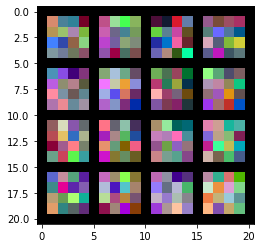

In [9]:
### - Train Loop - ###
size = 2**(Gen.depth+1)
print("Output Resolution: %d x %d" % (size, size))
for epoch in range(1+resume, epochs+1):
    Gen.train()
    D_epoch_loss = 0.0
    G_epoch_loss = 0.0
    if epoch-1 in schedule[0]:

        if (2 **(Gen.depth +1) < out_res):
            c = schedule[0].index(epoch-1)
            batch_size = schedule[1][c]
            growing = schedule[2][0]
            print("Growing network to size: " + str(2**(Gen.depth+1)))
            data_loader = DataLoader(dataset, **params)
            tot_iter_num = tot_iter_num = (len(dataset)/batch_size)
            Gen.inc_depth(growing*tot_iter_num)
            Disc.inc_depth(growing*tot_iter_num)
            size = 2**(Gen.depth+1)
            print("Output Resolution: %d x %d" % (size, size))

	
    print("epoch: %i/%i" % (int(epoch), int(epochs)))
    databar = tqdm(data_loader)
    for i, samples in enumerate(databar):
        ##  update D
        if size != out_res: #Basically need to, A Reshape, B prepare the data for the networks
            samples = F.interpolate(samples, size=(size,size)).to(device)
        else:
            samples = samples.to(device)
        Disc.zero_grad()
        noise = T.randn(samples.size(0), latent_size, 1, 1, device=device)
        fake = Gen(noise)
        #out_grid = make_grid(fake, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
        #plt.imshow(out_grid.cpu())
        fake_out = Disc(fake.detach())
        real_out = Disc(samples)
        ## Gradient Penalty
        
        eps = T.rand(samples.size(0), 1, 1, 1, device=device)
        eps = eps.expand_as(Gen(noise))
        x_hat = eps * samples + (1 - eps) * fake.detach()
        x_hat.requires_grad = True
        px_hat = Disc(x_hat)
        grad = T.autograd.grad(
                                    outputs = px_hat.sum(),
                                    inputs = x_hat, 
                                    create_graph=True
                                    )[0]
        grad_norm = grad.view(samples.size(0), -1).norm(2, dim=1)
        gradient_penalty = lambd * ((grad_norm  - 1)**2).mean()
        ###########

        D_loss = fake_out.mean() - real_out.mean() + gradient_penalty
        D_loss.backward()
        D_optimizer.step()

        ##	update G

        Gen.zero_grad()
        fake_out = Disc(fake)

        G_loss = - fake_out.mean()
        G_loss.backward()
        G_optimizer.step()

        ##############
        D_running_loss += abs(D_loss.item())
        G_running_loss += abs(G_loss.item())
        iter_num += 1
        if i % 3== 0:
            D_running_loss /= iter_num
            G_running_loss /= iter_num
            print('iteration : %d, gp: %.2f' % (i, gradient_penalty))
            databar.set_description('D_loss: %.3f   G_loss: %.3f' % (D_running_loss ,G_running_loss))
            iter_num = 0
            D_running_loss = 0.0
            G_running_loss = 0.0


    D_epoch_losses.append(D_epoch_loss/tot_iter_num)
    G_epoch_losses.append(G_epoch_loss/tot_iter_num)


    check_point = {'G_net' : Gen.state_dict(), 
                   'G_optimizer' : G_optimizer.state_dict(),
                   'D_net' : Disc.state_dict(),
                   'D_optimizer' : D_optimizer.state_dict(),
                   'D_epoch_losses' : D_epoch_losses,
                   'G_epoch_losses' : G_epoch_losses,
                   'fixed_noise': fixed_noise,
                   'depth': Gen.depth,
                   'alpha':Gen.alpha
                   }
    with T.no_grad():
        Gen.eval()
        T.save(check_point, check_point_dir + 'check_point_epoch_%d.pth' % (epoch))
        T.save(Gen.state_dict(), weight_dir + 'G_weight_epoch_%d.pth' %(epoch))
        out_imgs = Gen(fixed_noise).to(device)
        out_grid = make_grid(out_imgs, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
        plt.imshow(out_grid.cpu())
        plt.savefig(output_dir + 'size_%i_epoch_%d' %(size ,epoch))